# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

-----------:) 

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os

import lab02_functions as imPro
import skimage
import skimage.transform
from numpy.fft import fft

importlib.reload(imPro)

<module 'lab02_functions' from '/Users/anne-aimee/Desktop/ImageAnalysisLabs/lab02/lab02_functions.py'>

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

In [2]:
zeros=imPro.get_zeros()
ones = imPro.get_ones()

### Region based descriptors

We tested several region based descriptors : area and area in the polygon connecting the contour points, perimeter
wich are shift and rotation invariant but still scale variant. We can integrate them in the compacity descriptor, which becomes scale invariant. We also tested projection (which is variant in translation, rotation and scaling) and moments, invariant in translation, and moments, which can be tuned to standard centered moments and become invariant to rotation, shift and scaling.


In [3]:

def binarize(image):
    t =skimage.filters.threshold_mean(image)
    return image>t

#%% Region based Descriptors

def area(image):
    """
    Returns the area of the number
    :param image:  grayscale image of a number (white number on black background)
    """
    area=np.count_nonzero(image)
    return area


def perimeter(image):
    """
    Returns the perimeter of the number
    :param image:  grayscale image of a number (white number on black background)
    """
    perimeter=np.array(imPro.get_outmost_contour(img)).shape[1]
    return perimeter

def area_polygon(image):
    """
    Returns the area in the polygon connecting the contour points of the number
    :param image:  grayscale image of a number (white number on black background)
    """
    nb_inside= area(image)-perimeter(image)
    areap= perimeter(image)/2 +nb_inside -1
    return areap

def compacity(image):
    """
    Returns the compacity of the number
    :param image:  grayscale image of a number (white number on black background)
    """
    return perimeter(image)**2/area(image)

def projection(image):
    proj_x=[]
    proj_y=[]
    for i in range(image[0].shape[0]) :
        proj_y.append(np.count_nonzero(image[i]))
    for j in range (image[1].shape[0]):
        proj_x.append(np.count_nonzero(image[j]))
    return proj_x,proj_y

In [4]:
def moment (image,i,j) :
    m= 0
    for k in range(image[0].shape[0]):
        for l in range(image[0].shape[0]):
            m=m+pow(k,i)*pow(l,j)*image[k,l]/256
    return m

def centers_gravity (image):
    kc=moment(image,1,0)/moment(image,0,0)
    lc=moment(image,0,1)/moment(image,0,0)
    return [kc,lc]

def centered_moments(image,i,j,scaling_invariant=False) : #invariant to translation : center of gravity as origin
    mc= 0
    for k in range(image[0].shape[0]):
        for l in range(image[0].shape[0]):
            mc=mc+pow(k-centers_gravity(image)[0],i)*pow(l-centers_gravity(image)[1],j)*image[k,l]/256
    if scaling_invariant :
        gamma=int((i+j)/2)+1
        mc=centered_moments(image,i,j)/centered_moments(image,0,0)**gamma
    return mc

def standard_centered_moments(image,order=1,scaling_invariant=False):
    if (order==1):
        return centered_moments(image,2,0,scaling_invariant)+centered_moments(image,0,2,scaling_invariant)
    if (order==2):
        return (centered_moments(image,2,0,scaling_invariant)-centered_moments(image,0,2,scaling_invariant))**2 +4*centered_moments(image,1,1,scaling_invariant)
    if (order==3):
        return (centered_moments(image,3,0,scaling_invariant)-3*centered_moments(image,1,2,scaling_invariant))**2 + (3*centered_moments(image,2,1,scaling_invariant)-centered_moments(image,0,3,scaling_invariant))**2
    if (order==4) :
        return (centered_moments(image,3,0,scaling_invariant)+centered_moments(image,1,2,scaling_invariant))**2 + (centered_moments(image,2,1,scaling_invariant)+centered_moments(image,0,3,scaling_invariant))**2  
    return 

In [28]:
def region_based_features(images):
    """
    Returns an array of region based features for all the images in the input
    
    :param images:  group of grayscale images of numbers
    :return: param_images np.array of all the region based features of the input images
    """
    param_images = []
    for img in images:
        binary= binarize(img)
        param=[]
        param.append(area(binary))
        param.append(perimeter(binary))
        param.append(compacity(img))
        param.append(standard_centered_moments(img,1,False))
        param.append(standard_centered_moments(img,1,True))
        param_images.append(param)
    param_images = np.array(param_images)
    return param_images

In [29]:
param_zeros=region_based_features(zeros)
param_ones=region_based_features(ones)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

<Figure size 432x288 with 0 Axes>

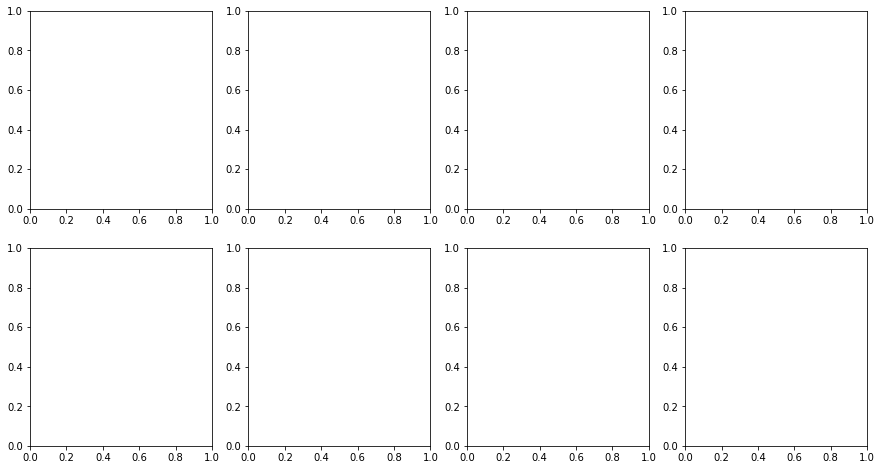

In [31]:
plt.figure()
fig, axs = plt.subplots(2,4, figsize = (15,8))

axs[0].plot(param_zeros[:,0], param_zeros[:,1],'.b', label = 'zeros')
axs[0].plot(param_ones[:,0], param_ones[:,1],'.r', label = 'ones')
axs[0].set_xlabel('Area ')
axs[0].set_ylabel('Perimeter ')
axs[0].set_title('Region based descriptors')
axs[0].legend()

axs[1].plot(param_zeros[:,2], param_zeros[:,2],'.b', label = 'zeros')
axs[1].plot(param_ones[:,3], param_ones[:,3],'.r', label = 'ones')
axs[1].set_xlabel('Compacity ')
axs[1].set_ylabel('centered moments ')
axs[1].set_title('Region based descriptors')
axs[1].legend()

axs[2].plot(param_zeros[:,0], param_zeros[:,4],'.b', label = 'zeros')
axs[2].plot(param_ones[:,0], param_ones[:,4],'.r', label = 'ones')
axs[2].set_xlabel('Area ')
axs[2].set_ylabel('Standard centered moment ')
axs[2].set_title('Region based descriptors')
axs[2].legend()

axs[3].plot(param_zeros[:,2], param_zeros[:,4],'.b', label = 'zeros')
axs[3].plot(param_ones[:,2], param_ones[:,4],'.r', label = 'ones')
axs[3].set_xlabel('Compacity ')
axs[3].set_ylabel('Standard centered moment ')
axs[3].set_title('Region based descriptors')
axs[3].legend()

plt.show()

The first plot indicates the differences between the area of the numbers calculated on the binary version compared to the area of the numbers on the original images.
It seems that there is small differences, that should be taken into account for choosing the parameters of interest

### 1.2 Fourier descriptors
Add your implementation and discussion

### 1.3 Additional method(s)
Add your implementation and discussion

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

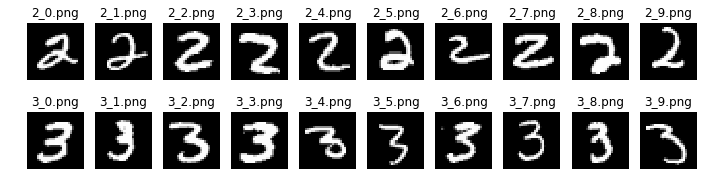

In [32]:
#  Load zeros
twos_path = 'lab-02-data/part2/2'
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = 'lab-02-data/part2/3'
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

In [30]:
param_twos= region_based_features(twos_im)
param_threes = region_based_features(threes_im)

NameError: name 'twos_im' is not defined

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

<Figure size 432x288 with 0 Axes>

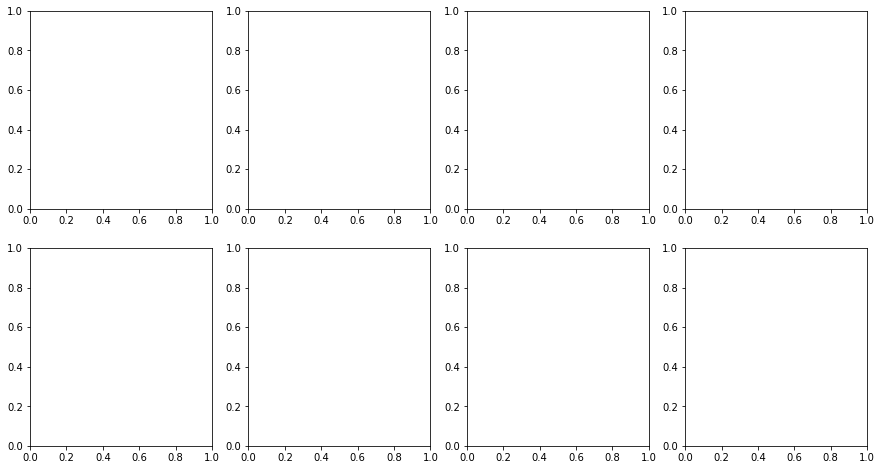

In [33]:


plt.figure()
fig, axs = plt.subplots(2,4, figsize = (15,8))

axs[0].plot(param_zeros[:,0], param_zeros[:,1],'.b', label = 'zeros')
axs[0].plot(param_ones[:,0], param_ones[:,1],'.r', label = 'ones')
axs[0].set_xlabel('Area ')
axs[0].set_ylabel('Perimeter ')
axs[0].set_title('Region based descriptors')
axs[0].legend()

axs[1].plot(param_zeros[:,2], param_zeros[:,2],'.b', label = 'zeros')
axs[1].plot(param_ones[:,3], param_ones[:,3],'.r', label = 'ones')
axs[1].set_xlabel('Compacity ')
axs[1].set_ylabel('centered moments ')
axs[1].set_title('Region based descriptors')
axs[1].legend()

axs[2].plot(param_zeros[:,0], param_zeros[:,4],'.b', label = 'zeros')
axs[2].plot(param_ones[:,0], param_ones[:,4],'.r', label = 'ones')
axs[2].set_xlabel('Area ')
axs[2].set_ylabel('Standard centered moment ')
axs[2].set_title('Region based descriptors')
axs[2].legend()

axs[3].plot(param_zeros[:,2], param_zeros[:,4],'.b', label = 'zeros')
axs[3].plot(param_ones[:,2], param_ones[:,4],'.r', label = 'ones')
axs[3].set_xlabel('Compacity ')
axs[3].set_ylabel('Standard centered moment ')
axs[3].set_title('Region based descriptors')
axs[3].legend()

plt.show()